In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from data import Sine_Data, Weather_Data
from models import RNN_periodic, local_LSTM, regularized_local_LSTM

# Load Pretrained Models

In [2]:
#load periodic/global model parameters
RNN_model_path = 'Results/periodic/model2.pth'
RNN_model = RNN_periodic(1,10,3)
RNN_model.load_state_dict(torch.load(RNN_model_path,weights_only=True,map_location=torch.device('cpu')))
RNN_model.eval()

RNN_periodic(
  (rnn): RNN(1, 10, num_layers=3)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [3]:
#load local LSTM model parameters (applied to noise)
LSTM_model_path = 'Results/local/model_hybrid.pth'
LSTM_model = local_LSTM(1, 20, 3)
LSTM_model.load_state_dict(torch.load(LSTM_model_path,weights_only=True,map_location=torch.device('cpu')))
LSTM_model.eval()

local_LSTM(
  (lstm): LSTM(1, 20, num_layers=3, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)

In [4]:
#load local model (applied to raw data)
LSTM_local_path = 'Results/local/model25.pth'
LSTM_local = local_LSTM(1,20,3)
LSTM_local.load_state_dict(torch.load(LSTM_local_path,weights_only=True,map_location=torch.device('cpu')))
LSTM_local.eval()

local_LSTM(
  (lstm): LSTM(1, 20, num_layers=3, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)

In [5]:
#local regualerized local LSTM
reg_LSTM_local_path = 'Results/local/regularized_local_model.pth'
reg_LSTM_local = regularized_local_LSTM(14,64,1)
reg_LSTM_local.load_state_dict(torch.load(reg_LSTM_local_path,weights_only=True,map_location=torch.device('cpu')))
reg_LSTM_local.eval()

regularized_local_LSTM(
  (input_mlp): Sequential(
    (0): Linear(in_features=14, out_features=28, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=28, out_features=64, bias=True)
  )
  (lstm): LSTM(64, 64)
  (blocks): Sequential(
    (0): ResBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (lin1): Linear(in_features=64, out_features=32, bias=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (lin2): Linear(in_features=32, out_features=64, bias=True)
      (lin3): Linear(in_features=64, out_features=64, bias=True)
      (act): ELU(alpha=1.0)
    )
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
  (act): ELU(alpha=1.0)
)

In [6]:
#define moving avarage
def moving_avarage(data_in, target_seq_len):
    Z = data_in.clone()
    result = torch.zeros(data_in.shape[0],target_seq_len,1)
    result[:,0] = Z.mean(1)
    for j in range(1,target_seq_len):
        Z = torch.cat([Z[:,1:],Z.mean(1).unsqueeze(-1)],1)
        result[:,j] = Z.mean(1)
    return result

In [7]:
def data_chunks(X, N, k): #N=seq_len, k=target size (k-step predictions)
    in_train = [X[i:i+N] for i in range(len(X)-N-k+1)]
    in_train = torch.stack(in_train,0)
    out_train = [X[i+N:i+N+k] for i in range(len(X)-N-k+1)]
    out_train = torch.stack(out_train,0)
    return in_train, out_train

# Data

In [8]:
synt_data = Sine_Data(2/365.25,3654,3/2)
X_sine = synt_data.x.unsqueeze(-1)

nat_data = Weather_Data('weather_prediction_dataset.csv','BASEL_temp_max')
X_raw = nat_data.tens
raw_in, raw_out = data_chunks(X_raw,14,7)

# Daily and Total Mean Squared Error for the Test Dataset

In [9]:
#moving avarage
out_mov_avg = moving_avarage(raw_in, 7)

In [10]:
# local model
H = torch.zeros(3,raw_in.shape[0],20)
c = torch.zeros(3,raw_in.shape[0],20)
local_LSTM_pred = LSTM_local(raw_in,H,c,7).detach()

In [11]:
#hybrid model:

# part 1: periodic RNN
H = torch.zeros(3,10)
periodic_data, _ = RNN_model(X_sine,H)
periodic_data = periodic_data.detach()



noise = X_raw - periodic_data
noise_in, __ = data_chunks(noise,14,7)
periodic_in, periodic_out = data_chunks(periodic_data,14,7)

#part 2: local LSTM
H = torch.zeros(3,noise_in.shape[0],20)
c = torch.zeros(3,noise_in.shape[0],20)
pred_noise = LSTM_model(noise_in,H,c,7).detach()

normalized_pred = pred_noise+periodic_out

In [12]:
# regularized local LSTM
H = torch.zeros(1, raw_in.shape[0], 64)
c = torch.zeros(1, raw_in.shape[0], 64)
X = raw_in
reg_LSTM_local_pred = torch.zeros(raw_in.shape[0],7,1)
for i in range(7):
    one_day, (H,c) = reg_LSTM_local(X, H, c)
    reg_LSTM_local_pred[:,i] = one_day.detach()
    X = torch.cat([X[:,1:].squeeze(-1), one_day],1).unsqueeze(-1)

In [13]:
days_of_years = [0]+[sum(366 if i % 4 == 0 else 365 for i in range(year+1)) for year in range(0,10)]
loss = nn.MSELoss()

#moving avarage
mov_avg_daily_loss = [round(loss(out_mov_avg[days_of_years[9]:,i],raw_out[days_of_years[9]:,i]).item(),4) for i in range(6)]
mov_avg_daily_loss.append(round(loss(out_mov_avg[days_of_years[9]:],raw_out[days_of_years[9]:]).item(),4))
#Local LSTM
LSTM_daily_loss = [round(loss(local_LSTM_pred[days_of_years[9]:,i],raw_out[days_of_years[9]:,i]).item(),4) for i in range(6)]
LSTM_daily_loss.append(round(loss(local_LSTM_pred[days_of_years[9]:], raw_out[days_of_years[9]:]).item(),4))
#hybrid model
hybrid_daily_loss = [round(loss(normalized_pred[days_of_years[9]:,i], raw_out[days_of_years[9]:,i]).item(),4) for i in range(6)]
hybrid_daily_loss.append(round(loss(normalized_pred[days_of_years[9]:], raw_out[days_of_years[9]:]).item(),4))
#regularized local LSTM
reg_LSTM_daily_loss = [round(loss(reg_LSTM_local_pred[days_of_years[9]:,i], raw_out[days_of_years[9]:,i]).item(),4) for i in range(6)]
reg_LSTM_daily_loss.append(round(loss(reg_LSTM_local_pred[days_of_years[9]:], raw_out[days_of_years[9]:]).item(),4))

columns = [f'{i+1}-day loss' for i in range(6)]
columns.append('total loss')

df = pd.DataFrame(columns=columns)
df.loc['moving avarage'] = mov_avg_daily_loss
df.loc['local LSTM'] = LSTM_daily_loss
df.loc['global RNN + local LSTM'] = hybrid_daily_loss
df.loc['regularized local LSTM'] = reg_LSTM_daily_loss
df

,1-day loss,2-day loss,3-day loss,4-day loss,5-day loss,6-day loss,total loss
moving avarage,0.2384,0.2628,0.2801,0.2984,0.3144,0.3214,0.2923
local LSTM,0.1375,0.1946,0.2165,0.2362,0.2628,0.2801,0.2319
global RNN + local LSTM,0.1157,0.1778,0.1879,0.1930,0.2044,0.2073,0.1850
regularized local LSTM,0.1304,0.2011,0.2247,0.2426,0.2682,0.2858,0.2360


# Analyzing Results - Hybrid Model

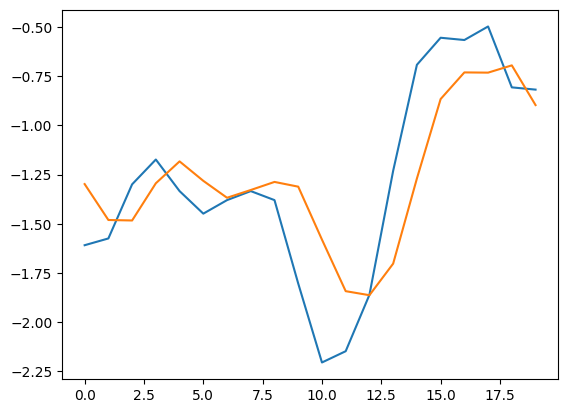

In [14]:
plt.plot(raw_out[:20,0,:])
plt.plot(normalized_pred[:20,0,:])

The next day's predictions tend to follow a similar pattern to the previous day's.

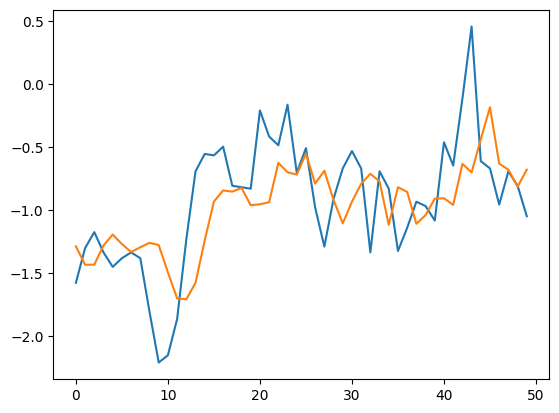

In [15]:
plt.plot(raw_out[:50,1,:])
plt.plot(normalized_pred[:50,1,:])

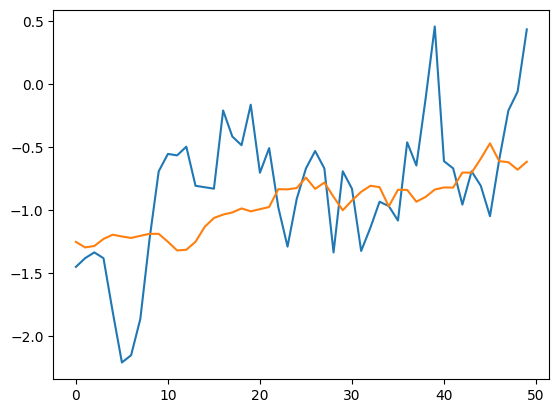

In [16]:
plt.plot(raw_out[:50,5,:])
plt.plot(normalized_pred[:50,5,:])

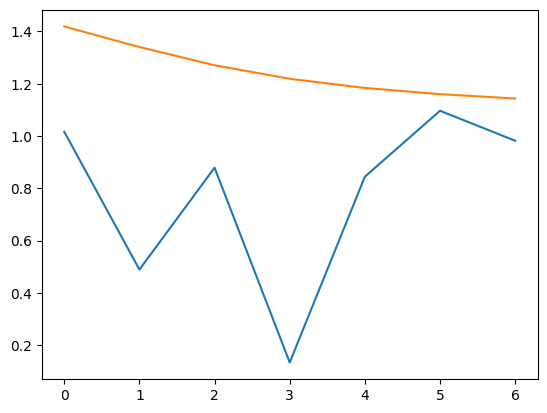

In [17]:
plt.plot(raw_out[200,:,:])
plt.plot(normalized_pred[200,:,:])

In [19]:
#Unnormalize
mean = nat_data.df_raw.mean()
std = nat_data.df_raw.std()
final_pred_out = (normalized_pred*std)+mean
original_out = (raw_out*std)+mean

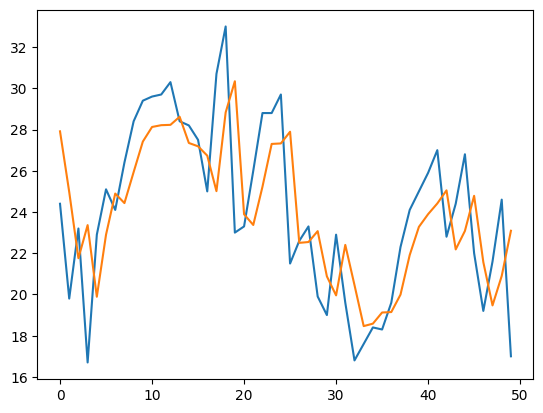

In [20]:
plt.plot(original_out[200:250,0,:])
plt.plot(final_pred_out[200:250,0,:])

In [21]:
def accuracy(pred, truth, k):
  prob = torch.zeros(pred.shape)
  for j in range(pred.shape[1]):
    for i in range(pred.shape[0]):
      if abs(pred[i,j] - truth[i,j]) <= k:
        prob[i,j] = 1
      else:
        prob[i,j] = 0
  return prob.mean(dim=0)

In [22]:
accuracy(final_pred_out, original_out,5.9) #next day prediction is %95 accurate in the range of +-5.9

tensor([[0.9499],
        [0.8814],
        [0.8514],
        [0.8360],
        [0.8222],
        [0.8110],
        [0.8126]])

In [23]:
final_pred_out.mean(0), final_pred_out.std(0)

(tensor([[15.5852],
         [15.5338],
         [15.5338],
         [15.5642],
         [15.6064],
         [15.6473],
         [15.6792]]),
 tensor([[8.0914],
         [7.8176],
         [7.6555],
         [7.5616],
         [7.5070],
         [7.4751],
         [7.4565]]))

In [25]:
original_out.mean(0), original_out.std(0)

(tensor([[15.5890],
         [15.5901],
         [15.5910],
         [15.5926],
         [15.5943],
         [15.5954],
         [15.5959]]),
 tensor([[8.7151],
         [8.7136],
         [8.7124],
         [8.7109],
         [8.7095],
         [8.7082],
         [8.7075]]))

In [24]:
diff = final_pred_out-original_out
diff.max(0), diff.min(0) # max and min error

(torch.return_types.max(
 values=tensor([[12.3296],
         [12.5492],
         [13.3021],
         [13.4566],
         [12.7232],
         [12.2760],
         [12.8259]]),
 indices=tensor([[1263],
         [2689],
         [2689],
         [2688],
         [2687],
         [1085],
         [1085]])),
 torch.return_types.min(
 values=tensor([[-11.6741],
         [-12.9765],
         [-13.3444],
         [-12.4601],
         [-12.4034],
         [-13.0640],
         [-12.3109]]),
 indices=tensor([[3629],
         [3628],
         [3627],
         [1520],
         [1519],
         [1518],
         [1517]])))